In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
AUTOTUNE = tf.data.AUTOTUNE

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
data_dir = "seg_train/seg_train" #Driection my files for training

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
#Im gonna use same traing data for my model validation step (0.2% data for val)

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


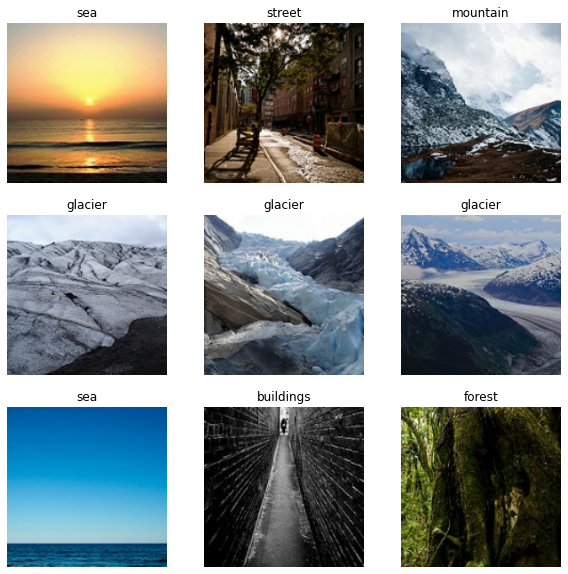

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
num_classes = 6

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
epochs=10
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
351/351 [==============================] - 372s 1s/step - loss: 1.2383 - accuracy: 0.5019 - val_loss: 0.7984 - val_accuracy: 0.6910
Epoch 2/10
351/351 [==============================] - 346s 986ms/step - loss: 0.7389 - accuracy: 0.7300 - val_loss: 0.7730 - val_accuracy: 0.7021
Epoch 3/10
351/351 [==============================] - 344s 980ms/step - loss: 0.5897 - accuracy: 0.7825 - val_loss: 0.6030 - val_accuracy: 0.7787
Epoch 4/10
351/351 [==============================] - 348s 991ms/step - loss: 0.4117 - accuracy: 0.8496 - val_loss: 0.6336 - val_accuracy: 0.7783
Epoch 5/10
351/351 [==============================] - 346s 987ms/step - loss: 0.2790 - accuracy: 0.9052 - val_loss: 0.5934 - val_accuracy: 0.8061
Epoch 6/10
351/351 [==============================] - 347s 989ms/step - loss: 0.1725 - accuracy: 0.9411 - val_loss: 0.7663 - val_accuracy: 0.7901
Epoch 7/10
351/351 [==============================] - 346s 985ms/step - loss: 0.1434 - accuracy: 0.9546 - val_loss: 0.9249 - va

In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "seg_test/seg_test",
  validation_split=0.01,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
#I like use 20% data from traing for validation then useing test data for ckecking my results

Found 3000 files belonging to 6 classes.
Using 2970 files for training.


In [15]:
model.evaluate(test_ds)

93/93 [==============================] - 27s 275ms/step - loss: 1.1320 - accuracy: 0.7798


[1.1319581270217896, 0.7797979712486267]

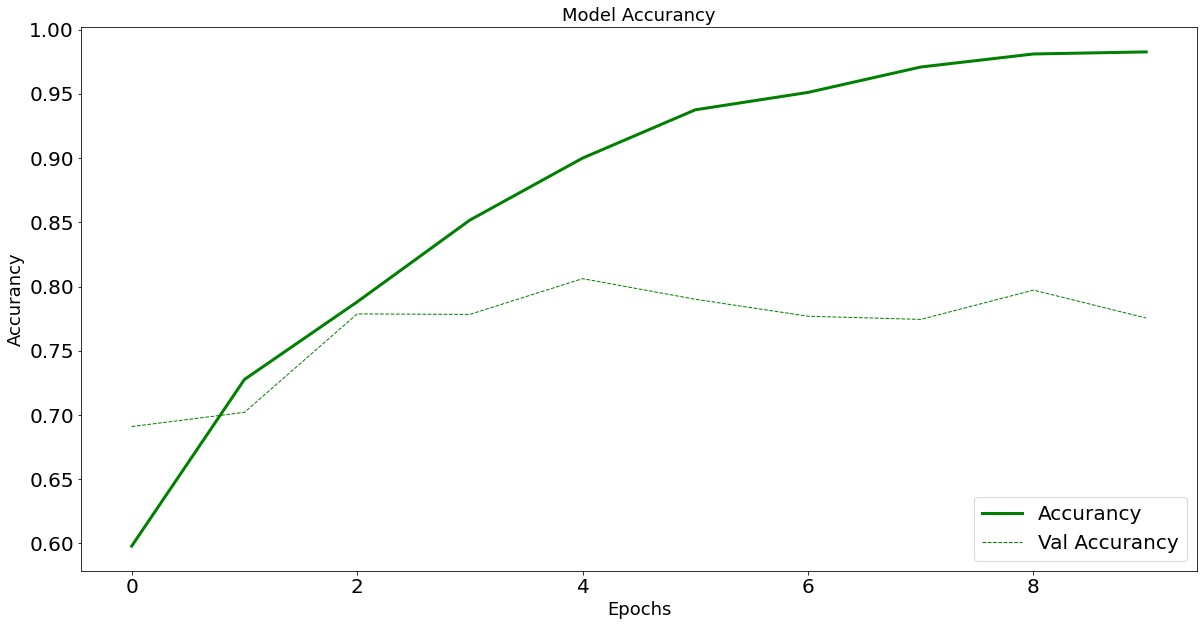

In [17]:
plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'],color='green',linewidth=3,label="Accurancy")
plt.plot(history.history['val_accuracy'],color='green',linewidth=1,linestyle="--",label="Val Accurancy")
plt.title("Model Accurancy",fontsize=18)
plt.xlabel("Epochs",fontsize=18)
plt.ylabel("Accurancy",fontsize=18)
plt.rcParams.update({'font.size': 20})
plt.legend(loc=4, prop={'size': 20})

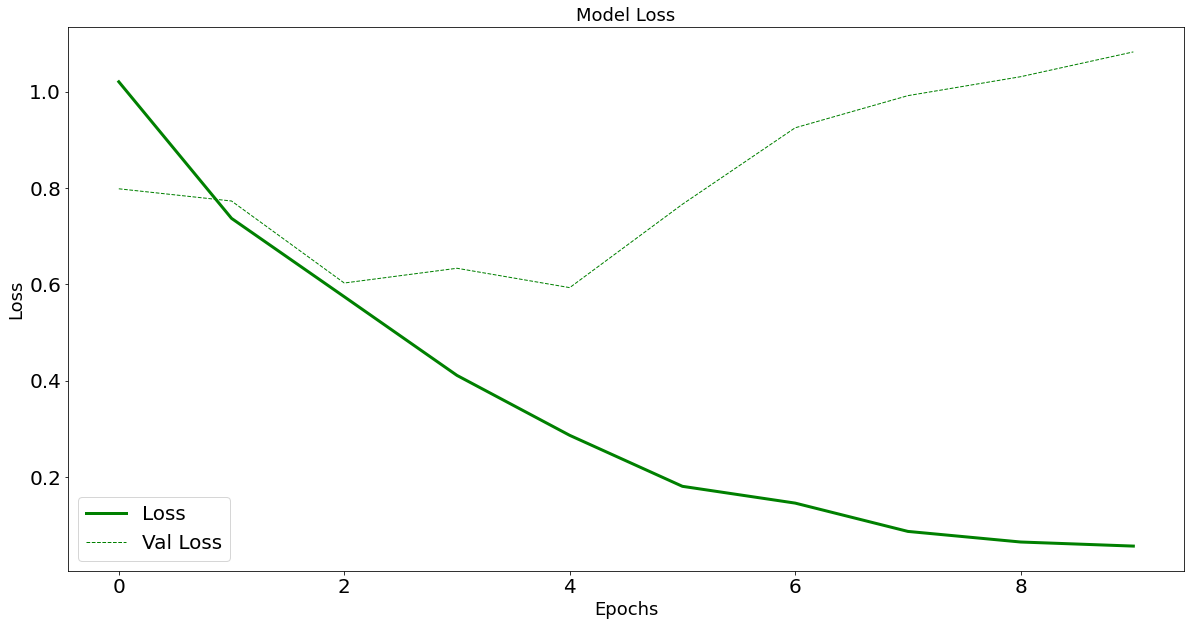

In [18]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'],color='green',linewidth=3,label="Loss")
plt.plot(history.history['val_loss'],color='green',linewidth=1,linestyle="--",label="Val Loss")
plt.title("Model Loss",fontsize=18)
plt.xlabel("Epochs",fontsize=18)
plt.ylabel("Loss",fontsize=18)
plt.rcParams.update({'font.size': 20})
plt.legend(loc=3, prop={'size': 20})

In [19]:
# Augmentation layer help us to make additional training..
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

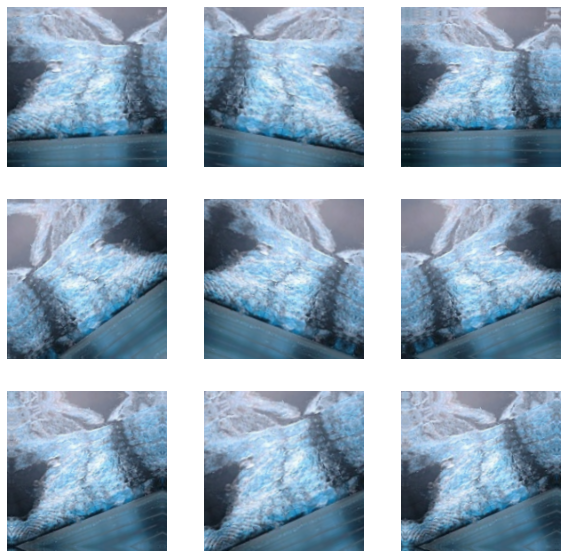

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
351/351 [==============================] - 312s 884ms/step - loss: 1.2888 - accuracy: 0.4883 - val_loss: 0.8900 - val_accuracy: 0.6547
Epoch 2/20
351/351 [==============================] - 310s 883ms/step - loss: 0.8500 - accuracy: 0.6853 - val_loss: 0.7493 - val_accuracy: 0.7327
Epoch 3/20
351/351 [==============================] - 312s 887ms/step - loss: 0.7800 - accuracy: 0.7096 - val_loss: 0.6982 - val_accuracy: 0.7520
Epoch 4/20
351/351 [==============================] - 302s 860ms/step - loss: 0.6725 - accuracy: 0.7494 - val_loss: 0.7701 - val_accuracy: 0.7281
Epoch 5/20
351/351 [==============================] - 301s 857ms/step - loss: 0.6449 - accuracy: 0.7612 - val_loss: 0.5959 - val_accuracy: 0.7876
Epoch 6/20
351/351 [==============================] - 300s 856ms/step - loss: 0.6121 - accuracy: 0.7823 - val_loss: 0.6160 - val_accuracy: 0.7794
Epoch 7/20
351/351 [==============================] - 299s 853ms/step - loss: 0.5885 - accuracy: 0.7857 - val_loss: 0.5745 -

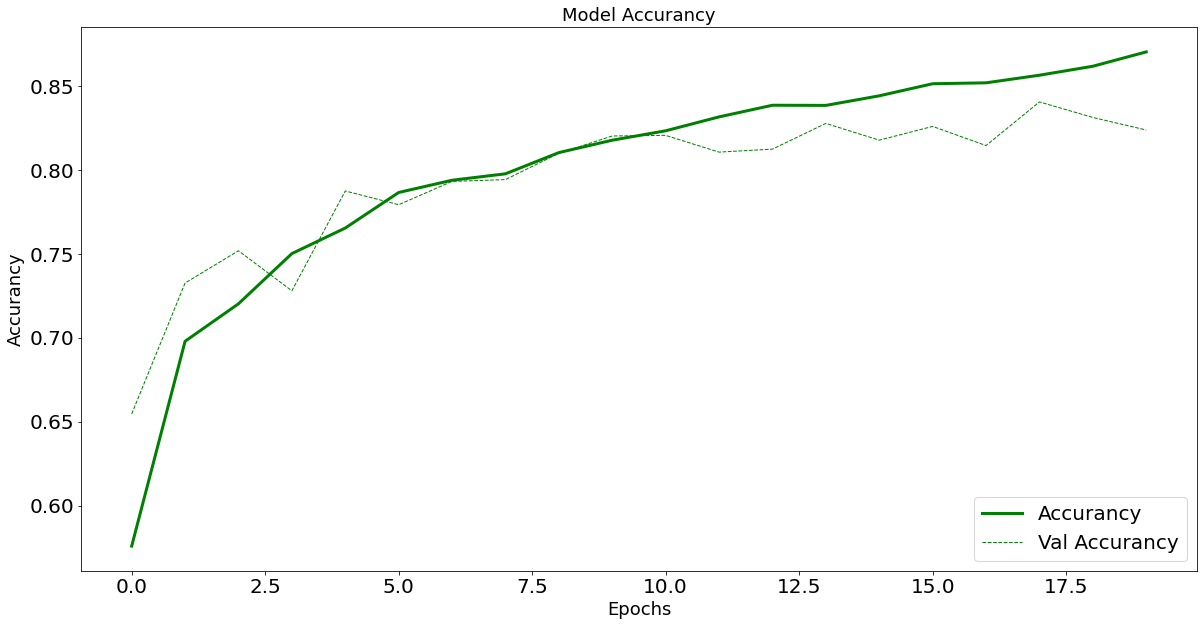

In [26]:
plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'],color='green',linewidth=3,label="Accurancy")
plt.plot(history.history['val_accuracy'],color='green',linewidth=1,linestyle="--",label="Val Accurancy")
plt.title("Model Accurancy",fontsize=18)
plt.xlabel("Epochs",fontsize=18)
plt.ylabel("Accurancy",fontsize=18)
plt.rcParams.update({'font.size': 20})
plt.legend(loc=4, prop={'size': 20})

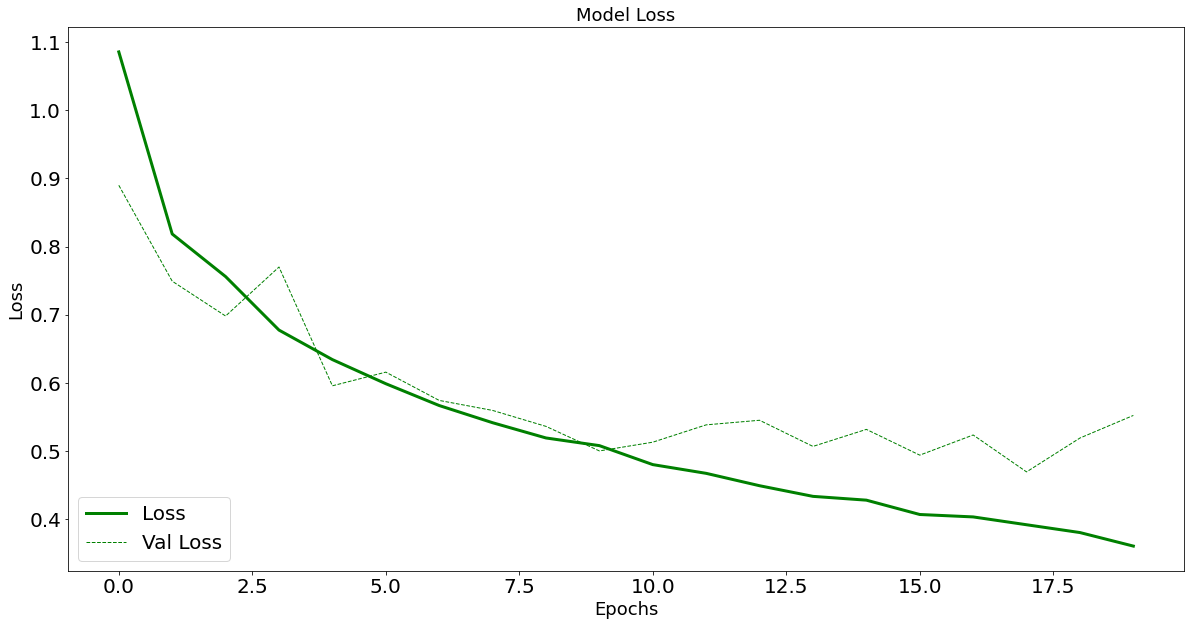

In [27]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'],color='green',linewidth=3,label="Loss")
plt.plot(history.history['val_loss'],color='green',linewidth=1,linestyle="--",label="Val Loss")
plt.title("Model Loss",fontsize=18)
plt.xlabel("Epochs",fontsize=18)
plt.ylabel("Loss",fontsize=18)
plt.rcParams.update({'font.size': 20})
plt.legend(loc=3, prop={'size': 20})

In [28]:
model.evaluate(test_ds)

93/93 [==============================] - 24s 247ms/step - loss: 0.5602 - accuracy: 0.8138


[0.5601851940155029, 0.8138046860694885]